In [345]:
# Data extraction from open-meteo API
import pandas as pd
import matplotlib.pyplot as plt
import requests

url = "https://archive-api.open-meteo.com/v1/era5"

params = {
    "latitude": 41.9027, # Geographical coordinates of Rome
    "longitude": 14.4963,
    "start_date": "2012-01-01", # Time interval to get weather data
    "end_date": "2022-12-31",  
    # Air temperature at 2 meters above ground, Windspeed at 10 meters above ground
    "hourly": "temperature_2m,windspeed_10m,shortwave_radiation,precipitation" 
}

response = requests.get(url, params = params)
data = response.json()

time_data = data["hourly"]["time"]
temperature_data = data["hourly"]["temperature_2m"]
windspeed_data = data["hourly"]["windspeed_10m"]
shortwave_radiation_data = data["hourly"]["shortwave_radiation"]
precipitation_data = data["hourly"]["precipitation"]

df = pd.DataFrame({"time":time_data, "temperature":temperature_data, "windspeed":windspeed_data, 
                   "shortwave_radiation":shortwave_radiation_data, "precipitation":precipitation_data})

df.head(2)

,time,temperature,windspeed,shortwave_radiation,precipitation
0,2012-01-01T00:00,-2.7,5.9,0.0,0.0
1,2012-01-01T01:00,-2.6,5.6,0.0,0.0


In [332]:
# In order to convert the time string to a datetime object we can use a UDF, then drop the old string column
def convert_to_datetime(time_str):
    return pd.to_datetime(time_str, format='%Y-%m-%dT%H:%M:%S')

df["time_converted"] = df["time"].apply(convert_to_datetime)

In [333]:
# Drop the old column time and rename the new one
new_df = df.drop("time", axis=1)
new_df.rename(columns={'time_converted': 'time'}, inplace=True)

In [334]:
# For semplicity we define the following time intervals for each season:
# Spring (march, april, may), Summer (june, july, august), Autumn (september, october, november), Winter (december, january, february)
# As first analysis, we want to find the max temperature registered for each summer:
dfSummer = new_df \
            .where((new_df["time"].dt.month >= 6) & (new_df["time"].dt.month <= 8)) \
            .groupby(new_df["time"].dt.year) \
            .agg( {"temperature":"max"} ) \
            .rename_axis(["year"]) \
            .sort_values(by = "year", ascending = False)

dfSummer

,temperature
year,
2022,34.1
2021,33.9
2020,32.0
2019,34.1
2018,30.4
2017,35.4
2016,30.8
2015,33.4
2014,30.8


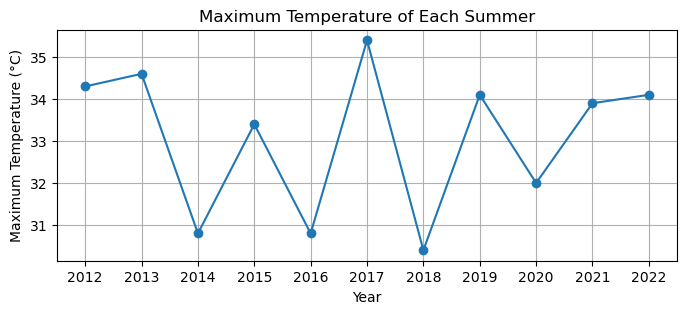

In [335]:
plt.figure(figsize=(8, 3))

plt.plot(dfSummer.index, dfSummer.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Maximum Temperature (°C)')
plt.title('Maximum Temperature of Each Summer')
plt.grid(True)
plt.xticks(dfSummer.index.astype(int))

plt.show()

In [336]:
# As second analysis, we want to discover and eventually find patterns about precipitation, 
# the period of the year with the most precipitation may vary from year to year
dfPrec = new_df \
            .where(new_df["precipitation"] > 0) \
            .groupby([new_df["time"].dt.year, new_df["time"].dt.month]) \
            .agg( {"precipitation":"sum"} ) \
            .rename_axis(["year", "month"]) \
            .reset_index()

dfPrec

,year,month,precipitation
0,2012,1,41.4
1,2012,2,117.2
2,2012,3,38.9
3,2012,4,89.7
4,2012,5,26.6
...,...,...,...
127,2022,8,23.0
128,2022,9,60.9
129,2022,10,12.5
130,2022,11,157.8


In [337]:
# We have to separate the season for each year:
# Spring (march, april, may), Summer (june, july, august), Autumn (september, october, november), Winter (december, january, february)
springMonths = [3, 4, 5]
summerMonths = [6, 7, 8]
autumnMonths = [9, 10, 11]
winterMonths = [12, 1, 2]

def calculateDfSeason(dfPrec, season):
    season = season.lower()
    
    if season == "spring":
        months = springMonths
    elif season == "summer":
        months = summerMonths
    elif season == "autumn":
        months = autumnMonths
    elif season == "winter":
        months = winterMonths
    else:
        months = []

    dfRes = dfPrec \
            .where( dfPrec["month"].isin(months) ) \
            .groupby( dfPrec["year"] ) \
            .agg( {"precipitation":"sum"} ) \
            .reset_index()
    
    dfRes["season"] = season
    
    return dfRes

In [338]:
dfSpring = calculateDfSeason(dfPrec, "spring")
dfSummer = calculateDfSeason(dfPrec, "summer")
dfAutumn = calculateDfSeason(dfPrec, "autumn")
dfWinter = calculateDfSeason(dfPrec, "winter")

In [339]:
dfFinal = pd.concat([dfSpring, dfSummer, dfAutumn, dfWinter], axis=0)

In [343]:
dfFinal = dfFinal.sort_values(by = "year")

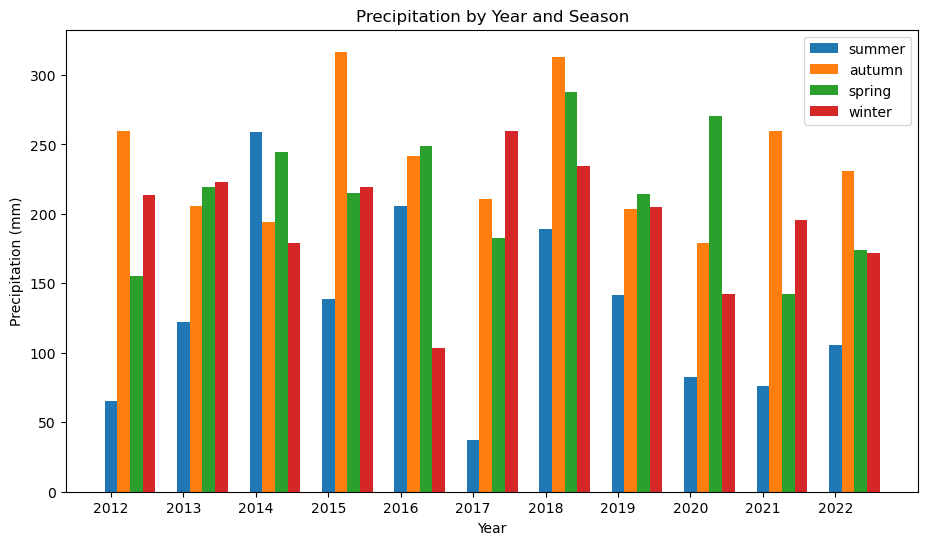

In [346]:
# Get the years and seasons as labels
years = dfFinal["year"].unique()
seasons = ["summer", "autumn", "spring", "winter"]

# Get the number of seasons and the width for each bar
num_seasons = len(seasons)
bar_width = 0.7 / num_seasons

# Create a figure and axis
fig, ax = plt.subplots(figsize=(11,6))

# Plot the bars for each season in each year
for i, season in enumerate(seasons):
    x = [j + i * bar_width for j in range(len(years))]
    data = dfFinal.where(dfFinal["season"] == season).dropna()
    ax.bar(x, data["precipitation"], width=bar_width, label=season, align="center")

# Set axis labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Precipitation (mm)')
ax.set_title('Precipitation by Year and Season')

# Set x-axis tick labels as years
ax.set_xticks(range(len(years)))
ax.set_xticklabels(years)

# Add a legend
ax.legend()

# Display the plot
plt.show()